In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
import dtreeviz

from tqdm import tqdm
import warnings
from pprint import pprint

warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("./data/augmented_data.csv")

In [3]:
data.nunique()

period                     5
minute                   139
second                    60
possession               290
duration               77925
competition_id            17
season_id                 41
match_id                3312
timestamp              82726
team                     288
player                  5638
freeze_frame           82866
play_pattern               9
position                  25
player_type                5
location_x               635
location_x_distance      635
location_y               701
location_y_distance      471
technique                  7
body_part                  4
type                       5
is_penalty                 2
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
aerial_won                 2
follows_dribble            2
under_pressure             2
pass_duration          11897
pass_angle             10504
pass_type                  8
pass_height                4
pass_length   

In [4]:
# Use mutual_info classification to check which features yield the most information about the target variable
data_copy = data.copy()
X = data_copy.drop(["statsbomb_xg", "is_goal", "end_location_x", "end_location_y", "shot_angle", "freeze_frame", "duration", "competition_id", "season_id", "match_id", "player", "timestamp", "team", "xg_so_far", "location_x", "location_y", "game_state", "body_part", "defenders_3m_radius", "under_pressure", "goal_distance", "play_pattern", "technique", "position", "body_part", "type", "pass_type", "pass_height"], axis=1)
mutual_info = mutual_info_classif(X, data["is_goal"])
mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info.sort_values(ascending=False)

distance_to_goalie     0.057946
shooting_range         0.052503
best_distance          0.049408
open_range             0.041420
defenders_triangle     0.041245
location_x_distance    0.035676
goalkeeper_x           0.028497
location_y_distance    0.022998
goalkeeper_y           0.022099
is_penalty             0.017511
own_past_minute        0.012997
open_goal              0.012847
pass_length            0.012442
pass_duration          0.009321
period                 0.008647
good_foot              0.007831
num_passes             0.007005
player_type            0.006258
was_leading            0.005626
first_time             0.005401
past_minute            0.005058
one_on_one             0.004239
pass_angle             0.003517
past_15                0.003196
aerial_won             0.002238
own_past_15            0.002170
shots_so_far           0.001895
minute                 0.001667
possession             0.000984
is_header              0.000901
follows_dribble        0.000641
second  

In [5]:
# drop redundant features
data.drop(["location_x", "location_y", "game_state", "body_part", "defenders_3m_radius", "under_pressure", "player_type", "best_distance"], axis=1, inplace=True)
# drop features that leak target information
data.drop(["end_location_x", "end_location_y", "shot_angle", "duration", "competition_id", "season_id", "match_id", "timestamp", "team", "player", "freeze_frame", "xg_so_far"], axis=1, inplace=True)
# drop low information features
data.drop(["period", "minute", "second", "possession", "aerial_won", "follows_dribble", "num_passes", "pass_length", "pass_duration", "pass_height", "pass_type", "pass_angle", "shots_so_far", "past_minute", "past_15", "own_past_minute", "own_past_15"], axis=1, inplace=True)
# drop penalties
data = data[data["is_penalty"] == False]

In [6]:
data.nunique()

play_pattern               9
position                  25
location_x_distance      635
location_y_distance      471
technique                  7
type                       4
is_penalty                 1
is_header                  2
first_time                 2
open_goal                  2
one_on_one                 2
defenders_triangle        12
goalkeeper_x             258
goalkeeper_y             355
distance_to_goalie     45441
shooting_range         43788
open_range                12
goal_distance          36856
statsbomb_xg           82416
is_goal                    2
good_foot                  2
was_leading                3
is_extra_time              2
dtype: int64

In [7]:
# one-hot encode the categorical data
encoded_data = data
for column_name in ["play_pattern", "technique", "type", "position"]:
    one_hot_encoded = pd.get_dummies(encoded_data[column_name], prefix=column_name)
    encoded_data = encoded_data.drop(column_name, axis=1)
    encoded_data = pd.concat([encoded_data, one_hot_encoded], axis=1)
data = encoded_data

In [8]:
data = data.dropna()
data.replace([np.inf, -np.inf], 0, inplace=True)

In [9]:
y1 = data["statsbomb_xg"]
y2 = data["is_goal"]
X = data.drop(["statsbomb_xg", "is_goal"], axis=1)

In [10]:
def preprocess_continuous(X, y):

    scaler = StandardScaler().fit(X)
    # X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    return X_train, X_test, y_train, y_test

In [11]:
def preprocess_classifier(X, y):

    scaler = StandardScaler().fit(X)
    X = scaler.transform(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

    X_train, y_train = SMOTE(sampling_strategy=0.2).fit_resample(X_train, y_train)

    return X_train, X_test, y_train, y_test

In [12]:
def calculate_errors(results_test, results_pred, name):
    mae = mean_absolute_error(results_test, results_pred)
    rmse = root_mean_squared_error(results_test, results_pred)
    r2 = r2_score(results_test, results_pred)
    print(f"\n{name}")
    print("Mean Absolute Error:", mae)
    print("Root Mean Squared Error:", rmse)
    print("R-squared (R2 Score):", r2)

In [13]:
def calculate_stats(results_test, results_pred, name):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not a goal", "Goal"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    accuracy = accuracy_score(results_test, results_pred)
    precision = precision_score(results_test, results_pred)
    recall = recall_score(results_test, results_pred)
    f1 = f1_score(results_test, results_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [14]:
def linear_regression():
    linear_r = LinearRegression()
    linear_r.fit(X_train, y_train)
    y_pred = linear_r.predict(X_test)

    calculate_errors(y_test, y_pred, "Linear Regression")

    return y_pred

In [15]:
X_train, X_test, y_train, y_test = preprocess_continuous(X, y1)
lr_xg = linear_regression()


Linear Regression
Mean Absolute Error: 0.03885812422763788
Root Mean Squared Error: 0.061737628948550984
R-squared (R2 Score): 0.751088532144331


In [16]:
gam_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())  # Assuming Gaussian family for continuous outcome
gam_result = gam_model.fit()
print(gam_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           statsbomb_xg   No. Observations:                57899
Model:                            GLM   Df Residuals:                    57842
Model Family:                Gaussian   Df Model:                           56
Link Function:               Identity   Scale:                        0.014031
Method:                          IRLS   Log-Likelihood:                 43431.
Date:                Thu, 09 May 2024   Deviance:                       756.22
Time:                        07:46:22   Pearson chi2:                     756.
No. Iterations:                   100   Pseudo R-squ. (CS):             0.1788
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0438      0.004     11.248      0.0

In [17]:
y_pred = gam_result.predict(X_test)
calculate_errors(y_test, y_pred, "GAM")


GAM
Mean Absolute Error: 0.09831388667422764
Root Mean Squared Error: 0.11433101086472724
R-squared (R2 Score): 0.14636325707483944


In [18]:
fpr1, tpr1, thresholds1 = roc_curve(y_test, y_pred)
roc_auc1 = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr1, tpr1, color='firebrick', lw=2, label='Our ROC curve (area = {:.2f})'.format(roc_auc1))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Plot the random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

ValueError: continuous format is not supported

In [ ]:
y_pred

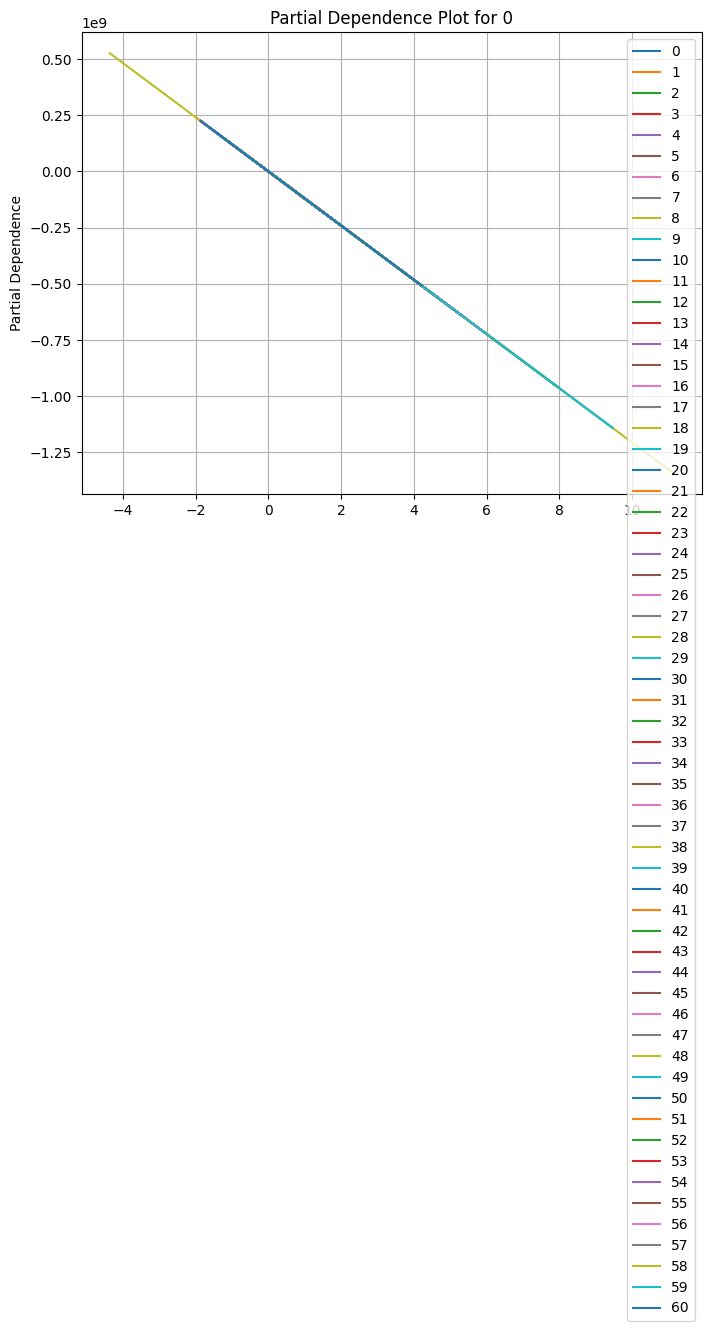

In [21]:
# Plot the partial dependence curve
plt.figure(figsize=(8, 6))

for index in range(0, 61):
    feature_values = np.linspace(X_test[index].min(), X_test[index].max(), num=50)

    # Function to compute partial dependence
    def compute_partial_dependence(model, feature_index, feature_values, other_features):
        X_pred = other_features.copy()
        results = []
        for value in feature_values:
            X_pred[feature_index] = value
            prediction = model.predict(X_pred)
            results.append(prediction.mean())  # Use mean prediction if multiple samples are used
        return results

    # Compute partial dependence for the feature of interest
    pdp_results = compute_partial_dependence(gam_result, index, feature_values, X_test)

    plt.plot(feature_values, pdp_results, label=index)

plt.ylabel('Partial Dependence')
plt.title(f'Partial Dependence Plot for {"0"}')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
X_test

array([[-0.57703715,  1.58933854,  0.        , ..., -0.32281453,
        -0.09050429, -0.02333122],
       [-0.30560633,  0.54516031,  0.        , ..., -0.32281453,
        -0.09050429, -0.02333122],
       [ 0.25987453,  0.66698111,  0.        , ..., -0.32281453,
        -0.09050429, -0.02333122],
       ...,
       [ 0.2372553 , -1.26474862,  0.        , ..., -0.32281453,
        -0.09050429, -0.02333122],
       [-0.83715834, -0.18576445,  0.        , ..., -0.32281453,
        -0.09050429, -0.02333122],
       [ 1.23250161, -1.40397238,  0.        , ..., -0.32281453,
        -0.09050429, -0.02333122]])